交叉验证分数:
平均密度: -0.3384 (+/- 1.2276)
下限密度: -0.7019 (+/- 2.2541)
上限密度: -0.2144 (+/- 0.8693)

R2 分数:
平均密度: -2.2927
下限密度: -1.6541
上限密度: -3.6353


/tmp/ipykernel_2168/3482528772.py:150: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2168/3482528772.py:150: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2168/3482528772.py:150: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2168/3482528772.py:150: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2168/3482528772.py:150: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2168/3482528772.py:150: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2168/3482528772.py:150: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.

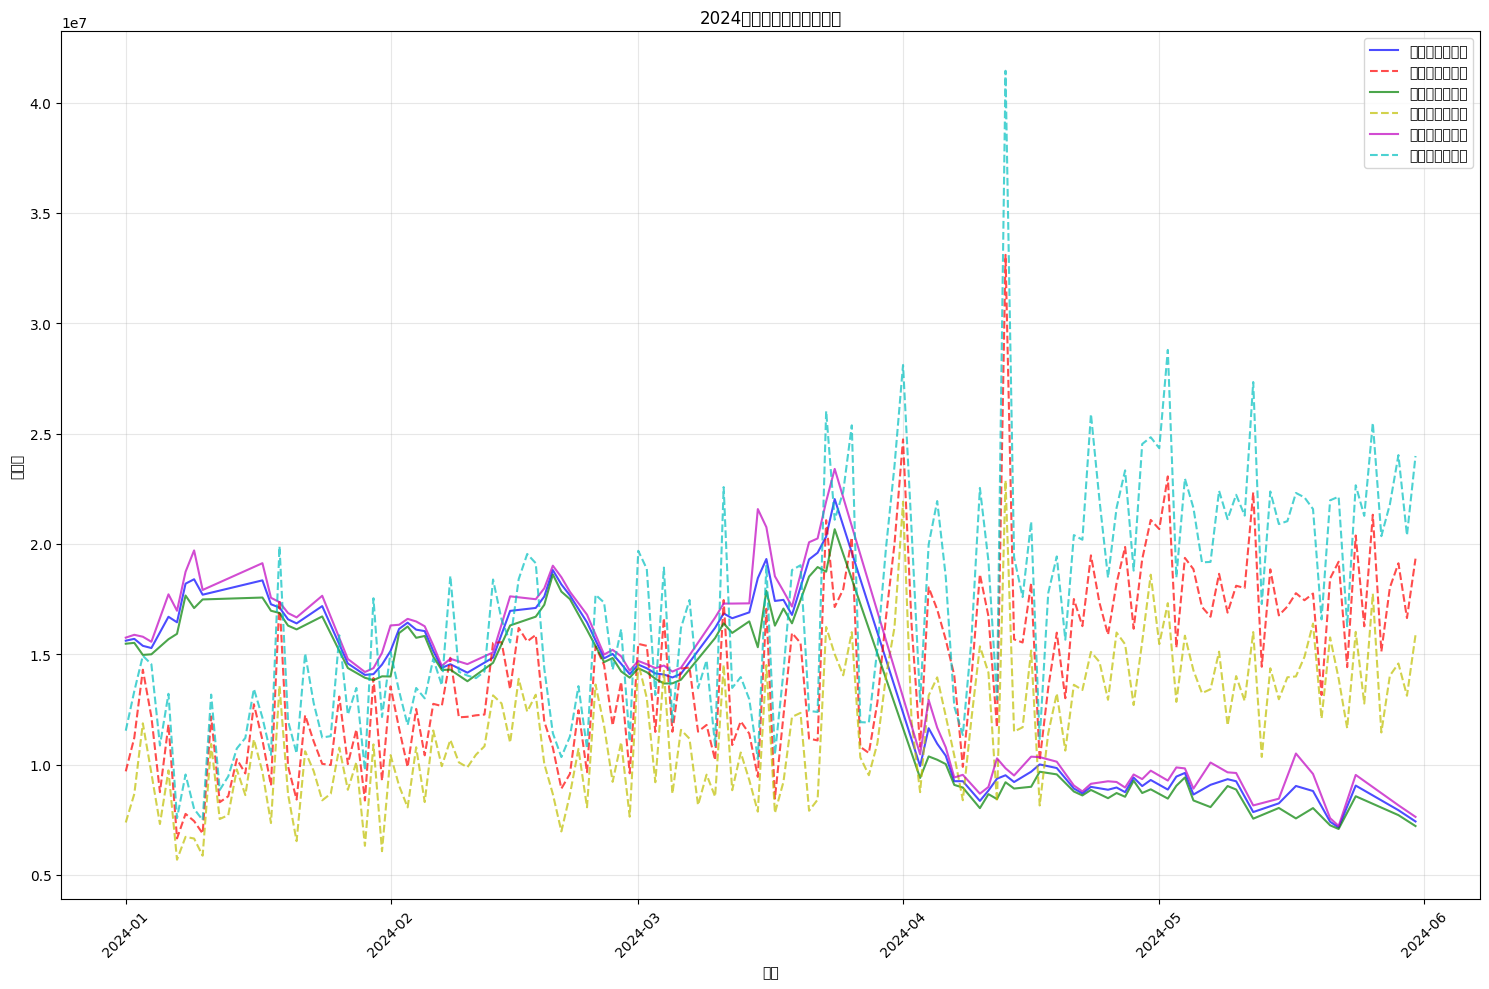


Feature importance for mean density prediction:
         feature  importance_mean
15  GMT_0900_PAR         0.085024
3            FAI         0.072225
12  GMT_0000_PAR         0.063792
1           ndvi         0.062393
2            evi         0.060540
22          MPAR         0.054994
21          PDVI         0.053082
14  GMT_0600_PAR         0.051742
13  GMT_0300_PAR         0.051664
20         DAPAR         0.051306


In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 读取两个CSV文件
mod_df = pd.read_csv('特征和密度结果_MODIS_MOD09GA_061_20241029_插值填充3.csv')
mcd_df = pd.read_csv('特征和密度结果_MODIS_MCD18C2_061_20241027_插值填充.csv')

# 重命名MCD数据框中的密度列,以区分来源
mcd_df = mcd_df.rename(columns={
    'density_mean': 'density_mean_mcd',
    'density_lower': 'density_lower_mcd', 
    'density_upper': 'density_upper_mcd'
})

# 重命名MOD数据框中的密度列
mod_df = mod_df.rename(columns={
    'density_mean': 'density_mean_mod',
    'density_lower': 'density_lower_mod',
    'density_upper': 'density_upper_mod'
})

# 合并两个数据框,以date为键
merged_df = pd.merge(mod_df, mcd_df, on='date')

# 计算两个来源的平均值作为最终密度值
merged_df['density_mean'] = merged_df['density_mean_mod']
merged_df['density_lower'] = merged_df['density_lower_mod']
merged_df['density_upper'] = merged_df['density_upper_mod']

# 将日期列转换为datetime类型
merged_df['date'] = pd.to_datetime(merged_df['date'])

# 定义特征列
features = ['ndci', 'ndvi', 'evi', 'FAI', 'nrfi', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7',
           'GMT_0000_PAR', 'GMT_0300_PAR', 'GMT_0600_PAR', 'GMT_0900_PAR', 'GMT_1200_PAR',
           'GMT_1500_PAR', 'GMT_1800_PAR', 'GMT_2100_PAR', 'DAPAR', 'PDVI', 'MPAR', 'APAR',
           'PPDI', 'PAI']

# 定义目标变量
targets = ['density_mean', 'density_lower', 'density_upper']

# 按日期划分训练集和测试集
train_df = merged_df[merged_df['date'] <= '2023-12-31']
test_df = merged_df[merged_df['date'] >= '2024-01-01']

# 准备训练集和测试集
X_train = train_df[features]
X_test = test_df[features]
y_mean_train = train_df['density_mean']
y_mean_test = test_df['density_mean']
y_lower_train = train_df['density_lower']
y_lower_test = test_df['density_lower']
y_upper_train = train_df['density_upper']
y_upper_test = test_df['density_upper']

# 创建并训练随机森林模型,增加参数以避免局部最优
rf_mean = RandomForestRegressor(
    n_estimators=500,  # 增加树的数量
    max_depth=None,    # 允许树充分生长
    min_samples_split=2, # 较小的分裂阈值允许更细致的学习
    min_samples_leaf=1,  # 叶节点最小样本数
    max_features='sqrt', # 在每次分裂时随机选择特征子集
    bootstrap=True,     # 使用bootstrap采样
    random_state=42,
    n_jobs=-1          # 使用所有CPU核心
)

rf_lower = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf_upper = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# 使用交叉验证训练模型
from sklearn.model_selection import cross_val_score

# 训练模型并进行交叉验证
cv_scores_mean = cross_val_score(rf_mean, X_train, y_mean_train, cv=5)
cv_scores_lower = cross_val_score(rf_lower, X_train, y_lower_train, cv=5)
cv_scores_upper = cross_val_score(rf_upper, X_train, y_upper_train, cv=5)

print("交叉验证分数:")
print(f"平均密度: {cv_scores_mean.mean():.4f} (+/- {cv_scores_mean.std() * 2:.4f})")
print(f"下限密度: {cv_scores_lower.mean():.4f} (+/- {cv_scores_lower.std() * 2:.4f})")
print(f"上限密度: {cv_scores_upper.mean():.4f} (+/- {cv_scores_upper.std() * 2:.4f})")

# 在完整训练集上训练最终模型
rf_mean.fit(X_train, y_mean_train)
rf_lower.fit(X_train, y_lower_train)
rf_upper.fit(X_train, y_upper_train)

# 预测并评估模型
y_mean_pred = rf_mean.predict(X_test)
y_lower_pred = rf_lower.predict(X_test)
y_upper_pred = rf_upper.predict(X_test)

# 计算R2分数
r2_mean = r2_score(y_mean_test, y_mean_pred)
r2_lower = r2_score(y_lower_test, y_lower_pred)
r2_upper = r2_score(y_upper_test, y_upper_pred)

print("\nR2 分数:")
print(f"平均密度: {r2_mean:.4f}")
print(f"下限密度: {r2_lower:.4f}")
print(f"上限密度: {r2_upper:.4f}")

# 绘制测试集的预测结果
plt.figure(figsize=(15, 10))

# 绘制实际值和预测值
plt.plot(test_df['date'], y_mean_test, 'b-', label='平均密度实际值', alpha=0.7)
plt.plot(test_df['date'], y_mean_pred, 'r--', label='平均密度预测值', alpha=0.7)
plt.plot(test_df['date'], y_lower_test, 'g-', label='下限密度实际值', alpha=0.7)
plt.plot(test_df['date'], y_lower_pred, 'y--', label='下限密度预测值', alpha=0.7)
plt.plot(test_df['date'], y_upper_test, 'm-', label='上限密度实际值', alpha=0.7)
plt.plot(test_df['date'], y_upper_pred, 'c--', label='上限密度预测值', alpha=0.7)

# 添加标题和标签
plt.title('2024年藻密度预测结果对比')
plt.xlabel('日期')
plt.ylabel('藻密度')
plt.legend()

# 旋转x轴日期标签以提高可读性
plt.xticks(rotation=45)

# 显示网格
plt.grid(True, alpha=0.3)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

# 计算特征重要性
feature_importance = pd.DataFrame({
    'feature': features,
    'importance_mean': rf_mean.feature_importances_,
    'importance_lower': rf_lower.feature_importances_,
    'importance_upper': rf_upper.feature_importances_
})

# 按平均密度的重要性排序
feature_importance = feature_importance.sort_values('importance_mean', ascending=False)
print("\nFeature importance for mean density prediction:")
print(feature_importance[['feature', 'importance_mean']].head(10))
